In [39]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from urllib import request as rq
import urllib
import re
import math
import os
import csv
import time
import json
import pickle
import sys
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
cwd = os.getcwd()
print(cwd)


/home/liam/Documents/info370


In [9]:
listOfWinners = open("AMPAS_bestpictures2.html")
soup = bs(listOfWinners, 'html.parser')

In [10]:
eles = soup.find('dl').contents
oscars = [["year", "Academy Award", "Winner", "Movie Name", "Producer"]]
oscarRound = []
eles = [e for e in eles if e != "\n"]
for row in eles:
    if row.name == "dt": # first element in seq
        if len(oscarRound) > 0:
            oscars.append(oscarRound)
            oscarRound = []
        aaindx = row.find('a').contents[0].split("(")[1].split(")")[0]
        year = row.find('a').contents[0].split("(")[0].split("/")[0].strip()
    if row.name == "table":
        movie = row.find_all("td")
        winner = "False"
        if len(movie[0].contents) > 0 and movie[0].contents[0] == "*":
            winner = "True"
        name = movie[1].find("div").find("i").find("a").contents[0]
        producer = movie[1].find("div").find("a", recursive=False).contents[0].split("(")[0].split(",")[0]
        oscarRound.append([year,aaindx,winner,name,producer])
print(oscars[60])
        
f = open("AA_bestpictures.csv", 'w')
fields = ", ".join(oscars.pop(0)) + "\n"
joined = ["\n".join([";".join(i) for i in x]) for x in oscars]
joined = "\n".join(joined)
joined = fields + joined
f.write(joined)
f.close()


[['1987', '60th', 'False', 'Broadcast News', 'James L. Brooks'], ['1987', '60th', 'False', 'Fatal Attraction', 'Stanley R. Jaffe and Sherry Lansing'], ['1987', '60th', 'False', 'Hope and Glory', 'John Boorman'], ['1987', '60th', 'True', 'The Last Emperor', 'Jeremy Thomas'], ['1987', '60th', 'False', 'Moonstruck', 'Patrick Palmer and Norman Jewison']]


In [11]:
imdbData = {}
imdbIds = {}

In [13]:
genreq = "http://www.omdbapi.com/?tomatoes=true&t="
missingimdb = []
inputs = []
outputs = []
for o in oscars:
    for m in o:
        e = False
        mname = str(m[3])
        myear = str(m[0]) 
        moviepage = rq.urlopen(genreq+urllib.parse.quote(mname) + "&y="+ urllib.parse.quote(myear))
        soup2 = bs(moviepage, 'html.parser')
        moviedat = json.JSONDecoder().decode(s=str(soup2))
        print(moviedat)
        if "Error" in moviedat:
            e = True
            myear = str(int(myear) + 1) 
            moviepage = rq.urlopen(genreq+urllib.parse.quote(mname) + "&y="+ urllib.parse.quote(myear))
            soup2 = bs(moviepage, 'html.parser')
            moviedat = json.JSONDecoder().decode(s=str(soup2))
            print(moviedat)
            if "Error" in moviedat:
                e = True
                missingimdb.append([mname, myear, moviedat['Error']])
        if not e:
            imdbRating = moviedat['imdbRating']
            imdbVotes = ''.join(moviedat['imdbVotes'].split(","))
            imdbId = moviedat['imdbID']
#                 tomURevs = float(''.join(moviedat['tomatoUserReviews'].split(",")))
#                 tomURating = float(moviedat['tomatoUserRating'])
#                 tomUMeter = float(moviedat['tomatoUserMeter'])
#                 tomRating = float(moviedat['tomatoRating'])
#             runtime = float(moviedat['Runtime'].split()[0])
            year = float(myear)

            if m[2] == "True":
                win = 1
            else:
                win = 0
            if imdbRating != "N/A" and imdbVotes != "N/A" and imdbId != "N/A":
                inputs.append([float(imdbRating),float(imdbVotes),year])
                outputs.append([win])
                imdbIds[mname] = imdbId
            else:
                missingimdb.append([mname, myear])



{'Error': 'Movie not found!', 'Response': 'False'}
{'imdbVotes': '641', 'imdbRating': '6.9', 'tomatoMeter': '100', 'tomatoConsensus': 'N/A', 'BoxOffice': 'N/A', 'Writer': 'Bartlett Cormack (from the stage success of), Bartlett Cormack (adaptation), Del Andrews (scenario), Tom Miranda (titles)', 'Rated': 'PASSED', 'Country': 'USA', 'Actors': 'Thomas Meighan, Louis Wolheim, Marie Prevost, G. Pat Collins', 'Response': 'True', 'Website': 'N/A', 'tomatoRotten': '0', 'tomatoUserReviews': '162', 'Director': 'Lewis Milestone', 'tomatoRating': '6.9', 'Language': 'English', 'Poster': 'http://ia.media-imdb.com/images/M/MV5BMTk5Mzc0MDY2N15BMl5BanBnXkFtZTgwMTg4MjQ3NDE@._V1._CR21,21,288,461_SX89_AL_.jpg_V1_SX300.jpg', 'DVD': 'N/A', 'Awards': 'N/A', 'Title': 'The Racket', 'Genre': 'Crime, Drama, Film-Noir', 'Production': 'Paramount Pictures', 'tomatoUserRating': '3.6', 'tomatoImage': 'fresh', 'Year': '1928', 'Plot': 'An honest police captain vows to bring down a powerful bootlegger who is protected b

In [14]:

imdblinks = []

In [15]:
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers={'User-Agent':user_agent,} 
missing2 = []
gsearch = "http://www.google.com/search?q=site:www.imdb.com+"
# imdblinks = np.array(imdblinks)
# for o in oscars:
#     for m in o:
for m in missingimdb:
    e = False
    mname = str(m[0])
    myear = str(m[1])
    if len([x for x in imdblinks if x[0] == mname]) == 0:
        url = gsearch+mname.replace(" ","+") + "+"+ myear
        print(url)
        request=urllib.request.Request(url,None,headers) #The assembled request
        response = urllib.request.urlopen(request)
        data = response.read() # The data u need
#         print(data)
        soup2 = bs(data, 'html.parser')
#         print(soup2)
        firstres = soup2.find("div", id="search").find_all("div", class_="g")[0]
        print(firstres)

#         imdblink = firstres.find("h3").find("a", href=True)['href']
        imdblink = firstres.find("cite").contents[0]
        parts = imdblink.split("/")
        if parts[0] == "www.imdb.com" and parts[1] =='title':
            imdblink = "/".join(parts[:3])
            print(imdblink)
            imdbIds[mname] = parts[2]
            imdblinks.append([mname, myear,imdblink])
        else:
            print("Wasn't first link!")
            missing2.append([mname, myear,"Wasn't first link!"])
        time.sleep(2)
    else:
        print("already had this one.")
print("One round done. Sleeping for five secs.")
time.sleep(5) # delays for 5 seconds



http://www.google.com/search?q=site:www.imdb.com+Alibi+1928
<div class="g"><h3 class="r"><a href="/url?q=http://www.imdb.com/title/tt0019031/literature&amp;sa=U&amp;ved=0ahUKEwjk5MHkqpXQAhVHjFQKHUA4C9EQFggUMAA&amp;usg=AFQjCNGY5h67se1SeCq4oGeg_2VwelJ32Q">Hubby's Latest <b>Alibi</b> (<b>1928</b>) - Literature - IMDb</a></h3><div class="s"><div class="kv" style="margin-bottom:2px"><cite>www.imdb.com/title/tt0019031/literature</cite></div><span class="st">Hubby's Latest <b>Alibi</b> on IMDb: Movies, TV, Celebs, and more...</span><br/></div></div>
www.imdb.com/title/tt0019031
http://www.google.com/search?q=site:www.imdb.com+The+Patriot+1928
<div class="g"><h3 class="r"><a href="/url?q=http://www.imdb.com/title/tt0019257/&amp;sa=U&amp;ved=0ahUKEwitwN3lqpXQAhWojFQKHQ5KD0QQFggUMAA&amp;usg=AFQjCNFBY3JqmDaJ9jF0v8WhI2e0fmUMnA"><b>The Patriot</b> (<b>1928</b>) - IMDb</a></h3><div class="s"><div class="kv" style="margin-bottom:2px"><cite>www.imdb.com/title/tt0019257/</cite><div class="_nBb">‎<div a

In [16]:
imdbIds["Cries and Whispers"] = "tt0069467"
imdbIds["Casablanca"] = "tt0034583"

In [45]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
sys.setrecursionlimit(50000)

print(len(oscars))
# print(len(missingimdb))
print(len(imdbIds.items()))
projectData = {
    "imdbIDs": imdbIds,
    "ImdbLinks": imdblinks,
    "oscars": oscars
}
save_obj(projectData, "projectData")


87
492


In [53]:
projectData = load_obj("projectData")
imdbIds = projectData["imdbIDs"]


In [54]:
imdbData = {}
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers={'User-Agent':user_agent} 
failedReqs = []


# gsearch = "http://www.imbd.com/title/"
for key, imdbID in imdbIds.items():
    link = "http://www.imbd.com/title/"+imdbID+"/"
    print(key)
    print(link)
    try:
        request=urllib.request.Request(link,None,headers) #The assembled request
        response = urllib.request.urlopen(request)
        data = response.read() # The data u need
        soup2 = bs(data, 'html.parser')
    except urllib.error.URLError as e:
        print(e.reason)  
        print(link)

        failedReqs.append(link)
    try:
        mainSection = soup2.find("div",{"id":"main_top"})
        print(soup2)
    #     tbar = mainSection.find("div", class_="title_bar_wapper")
    #     ratingbar = tbar.find("div",class_="ratings_wrapper").find("div",class_="imdbRating")
    #     rating = ratingbar.find("div",class_="ratingValue").find("strong").find("span").contents[0]
        rating = mainSection.find("span",{"itemprop": "ratingValue"}).contents[0]

        votes = mainSection.find("span",{"itemprop": "ratingCount"}).contents[0]
        year = mainSection.find("span", {"id":"titleYear"}).find("a").contents[0]
        reviews = mainSection.find("div",class_="imdbRating").find("div", class_="hiddenImportant").find_all("span")
        userRevs = 0
        criticRevs = 0
        try:
            userRevs = reviews[0].contents[0].split()[0]
            criticRevs = reviews[1].contents[0].split()[0]
        except IndexError:
            print("couldnt't find the review tag")
            print(reviews)
            failedReqs.append(link)
            
        actors = []
        actortags = mainSection.find("div", class_="plot_summary").find_all("span", {"itemprop": "actors"})
        for tag in actortags:
            actors.append(tag.find("a").find("span").contents[0])

        details = soup2.find("div",{"id":"titleDetails"})
        runtime = details.find("time",{"itemprop":"duration"}).contents[0].split()[0]
        releasedate = soup2.find("meta",{"itemprop":"datePublished"})['content']
#         print(key)
#         print(link)
        print(rating)
        print(votes)
        print(userRevs)
        print(criticRevs)
        print(actors)
        print(runtime)
        imdbData[key] = [key, year, link, rating, votes, userRevs, criticRevs, actors, runtime, releasedate]
    except AttributeError as e:
        print("couldnt't find some attribute: %s" % e)
        print(link)
        failedReqs.append(link)
    time.sleep(3)
print(failedReqs)
#     break
    

Erin Brockovich
http://www.imbd.com/title/tt0195685/
[Errno -3] Temporary failure in name resolution
http://www.imbd.com/title/tt0195685/
<html><head><title>Bot or Human</title>
<meta content="" name="please_ignore_me"/>
<style>
body{
	font-family:arial;
}</style>
<script type="text/javascript">
var _0x7393=["\x73\x75\x62\x73\x74\x72\x69\x6E\x67","\x73\x65\x61\x72\x63\x68","\x6C\x6F\x63\x61\x74\x69\x6F\x6E","\x26","\x73\x70\x6C\x69\x74","\x6C\x65\x6E\x67\x74\x68","\x3D","\x51\x75\x65\x72\x79\x20\x56\x61\x72\x69\x61\x62\x6C\x65\x20","\x20\x6E\x6F\x74\x20\x66\x6F\x75\x6E\x64","\x69\x6E\x6E\x65\x72\x48\x54\x4D\x4C","\x78\x64\x69\x76","\x67\x65\x74\x45\x6C\x65\x6D\x65\x6E\x74\x42\x79\x49\x64","\x3C\x66\x6F\x72\x6D\x20\x6D\x65\x74\x68\x6F\x64\x3D\x22\x70\x6F\x73\x74\x22\x20\x61\x63\x74\x69\x6F\x6E\x3D\x22\x69\x6E\x64\x65\x78\x32\x2E\x70\x68\x70\x22\x3E\x3C\x63\x65\x6E\x74\x65\x72\x3E","\x3C\x66\x6F\x6E\x74\x20\x73\x74\x79\x6C\x65\x3D\x22\x66\x6F\x6E\x74\x2D\x73\x69\x7A\x65\x3A\x30\x2E\x37\x

KeyboardInterrupt: 

In [31]:
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
my_referer = "http://www.google.com/search?q=site:www.imdb.com+Cries+and+Whispers+1974"
headers={'User-Agent':user_agent,'referer': my_referer} 
link = "http://www.imbd.com/title/tt0087553/"
candidate_proxies = [
                     
                     '173.201.183.172:8000']
for p in candidate_proxies:
    print("Trying HTTP proxy %s" % proxy)
#     try:
    proxy = urllib.request.ProxyHandler({'http': p})
    opener = urllib.request.build_opener(proxy)
    # install the openen on the module-level
    urllib.request.install_opener(opener)
    # make a request
    
#     response = urllib.request.urlretrieve(link, headers = headers)
    request = urllib.request.Request(link,headers=headers)
    response = urllib.request.urlopen(request)
    data = response.read() # The data u need
    soup2 = bs(data, 'html.parser')
    print("Got URL using proxy %s" % proxy)
    print(soup2)
#     except:
#         print("Trying next proxy in 5 seconds")
#         time.sleep(5)
# request=urllib.request.Request(link,None,headers) #The assembled request
# response = urllib.request.urlopen(request)
# data = response.read() # The data u need
# soup2 = bs(data, 'html.parser')

Trying HTTP proxy <urllib.request.ProxyHandler object at 0x7f42b653b4e0>
Got URL using proxy <urllib.request.ProxyHandler object at 0x7f42b653c240>
<html><head><title>Bot or Human</title>
<meta content="" name="please_ignore_me"/>
<style>
body{
	font-family:arial;
}</style>
<script type="text/javascript">
var _0x7393=["\x73\x75\x62\x73\x74\x72\x69\x6E\x67","\x73\x65\x61\x72\x63\x68","\x6C\x6F\x63\x61\x74\x69\x6F\x6E","\x26","\x73\x70\x6C\x69\x74","\x6C\x65\x6E\x67\x74\x68","\x3D","\x51\x75\x65\x72\x79\x20\x56\x61\x72\x69\x61\x62\x6C\x65\x20","\x20\x6E\x6F\x74\x20\x66\x6F\x75\x6E\x64","\x69\x6E\x6E\x65\x72\x48\x54\x4D\x4C","\x78\x64\x69\x76","\x67\x65\x74\x45\x6C\x65\x6D\x65\x6E\x74\x42\x79\x49\x64","\x3C\x66\x6F\x72\x6D\x20\x6D\x65\x74\x68\x6F\x64\x3D\x22\x70\x6F\x73\x74\x22\x20\x61\x63\x74\x69\x6F\x6E\x3D\x22\x69\x6E\x64\x65\x78\x32\x2E\x70\x68\x70\x22\x3E\x3C\x63\x65\x6E\x74\x65\x72\x3E","\x3C\x66\x6F\x6E\x74\x20\x73\x74\x79\x6C\x65\x3D\x22\x66\x6F\x6E\x74\x2D\x73\x69\x7A\x65\x3A\x30

In [101]:
f = open("AA_bestpictures.csv", 'r')
csvRows = csv.reader(f, delimiter=';', quotechar='"')
for indx, row in enumerate(csvRows):
    if indx > 0:
        print(row)
        

['1927', '1st', 'False', 'The Racket', 'The Caddo Company']
['1927', '1st', 'False', '7th Heaven', 'Fox']
['1927', '1st', 'True', 'Wings', 'Paramount Famous Lasky']
['1928', '2nd', 'False', 'Alibi', 'Feature Productions']
['1928', '2nd', 'False', 'In Old Arizona', 'Fox']
['1928', '2nd', 'True', 'The Broadway Melody', 'Metro-Goldwyn-Mayer']
['1928', '2nd', 'False', 'Hollywood Revue', 'Metro-Goldwyn-Mayer']
['1928', '2nd', 'False', 'The Patriot', 'Paramount Famous Lasky']
['1929', '3rd', 'True', 'All Quiet on the Western Front', 'Universal']
['1929', '3rd', 'False', 'The Big House', 'Cosmopolitan']
['1929', '3rd', 'False', 'Disraeli', 'Warner Bros.']
['1929', '3rd', 'False', 'The Divorcee', 'Metro-Goldwyn-Mayer']
['1929', '3rd', 'False', 'The Love Parade', 'Paramount Famous Lasky']
['1930', '4th', 'True', 'Cimarron', 'RKO Radio']
['1930', '4th', 'False', 'East Lynne', 'Fox']
['1930', '4th', 'False', 'The Front Page', 'The Caddo Company']
['1930', '4th', 'False', 'Skippy', 'Paramount Publ

In [2]:
pls = PLSRegression(n_components=3, max_iter=30000)
pls.fit(inputs,outputs)
pred = pls.predict(inputs)
pls.score(inputs,outputs)
# pls.get_params()

NameError: name 'PLSRegression' is not defined

In [3]:
good = 0
for p, x in zip(pred,outputs):
    p = p[0]
    x = x[0]
    if x == 0:
        if p < .05:
            good = good + 1
    else:
        if p > .95:
            good = good + 1
print(str(good/len(outputs)*100))
offset = np.array(outputs) - pred
plt.hist(offset)
plt.show()

NameError: name 'pred' is not defined

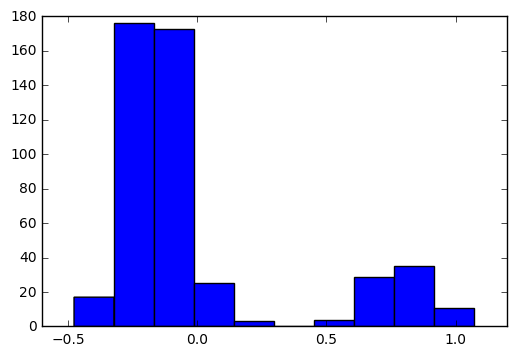

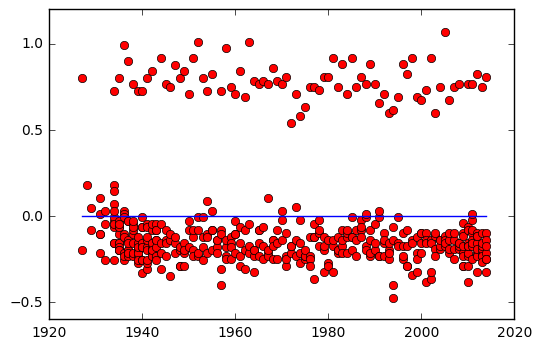

In [337]:
imratings = [i[0] for i in inputs]
imvotes = [i[1] for i in inputs]
yr = [i[2] for i in inputs]
plt.plot(yr, offset, "ro", yr, [0 for i in yr], "-")
plt.show()

In [338]:
in2 = [ in2 for in2,out2 in zip(inputs,outputs) if out2[0] == 1]
out2 = [ out2 for in2,out2 in zip(inputs,outputs) if out2[0] == 1]


# pls2 = PLSRegression(n_components=3, max_iter=30000)
# pls.fit(in2,out2)
pred2 = pls.predict(in2)
pls.score(in2,out2)
# pls2.get_params()


imr2 = [i[0] for i in in2]
imv2 = [i[1] for i in in2]
yr2 = [i[2] for i in in2]
offset2 = np.array(out2) - pred2


In [339]:
pls.predict(in2)

array([[ 0.19651423],
       [ 0.27163342],
       [ 0.19622181],
       [ 0.00774775],
       [ 0.10192994],
       [ 0.23379966],
       [ 0.2714508 ],
       [ 0.27141412],
       [ 0.19600249],
       [ 0.15827844],
       [ 0.08283032],
       [ 0.23354379],
       [ 0.252351  ],
       [ 0.12040817],
       [ 0.19574662],
       [ 0.15802256],
       [ 0.28989233],
       [ 0.08257447],
       [-0.01168085],
       [ 0.19556387],
       [ 0.27090239],
       [ 0.176647  ],
       [ 0.27079278],
       [ 0.02578734],
       [ 0.25187593],
       [ 0.28952683],
       [ 0.15758399],
       [ 0.30829755],
       [-0.01208293],
       [ 0.21400557],
       [ 0.23281285],
       [ 0.21393243],
       [ 0.23273965],
       [ 0.13848432],
       [ 0.21382282],
       [ 0.23263001],
       [ 0.19490597],
       [ 0.45868296],
       [ 0.2890517 ],
       [ 0.420922  ],
       [ 0.36435409],
       [ 0.25125474],
       [ 0.25121801],
       [ 0.27002524],
       [ 0.19461356],
       [ 0

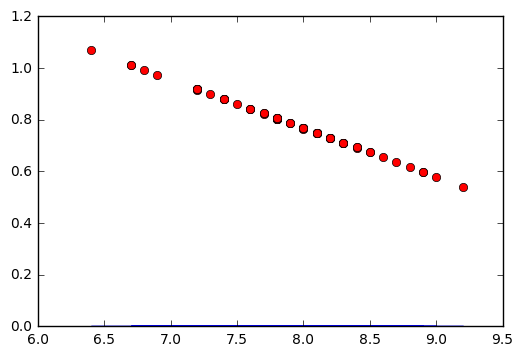

In [340]:
plt.plot(imr2, offset2, "ro", imr2, [0 for i in imr2], "-")
plt.show()